In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

## Reading Files

In [31]:
# ADMET properties.
admet = pd.read_csv('../Data/FDB_admet.tsv', sep='\t')

# 2d-3d properties.
twod_threed = pd.read_csv('../Data/FDB_twod_threed.tsv', sep='\t')

# Pubchem properties
pubchem_prop = pd.read_csv('../Data/FDB_pubchem_prop.tsv', sep='\t', index_col='Unnamed: 0')
pubchem_prop.fillna('', inplace=True)

# Drop certain columns

## Identifiers.
twod_threed.drop(['Molecular_Formula', 'Molecular_Composition'], inplace=True, axis=1)
pubchem_prop.drop(['IUPACName', 'common_name', 'CanonicalSMILES', 'IsomericSMILES',
                   'cas_id', 'fema_number', 'InChI'], 
                  inplace=True, axis=1)
admet.drop(['ADMET_BBB', 'ADMET_EXT_Hepatotoxic_Applicability', 'ADMET_EXT_PPB_Applicability'],
           inplace=True, axis=1)

## Large number of missing values or no variability.
twod_threed.drop(['pKa', 'Num_HydrogenBonds'], inplace=True, axis=1)

# Outlier data point.
# Set pubchem_id as index for each.
twod_threed = twod_threed.set_index('pubchem_id').drop([24763, 58059732, 4873, 24015, 59514401, 59514406], axis=0)
pubchem_prop = pubchem_prop.set_index('pubchem_id').drop([24763, 58059732, 4873, 24015, 59514401, 59514406], axis=0)
admet = admet.set_index('pubchem_id').drop([24763, 58059732, 4873, 24015, 59514401, 59514406], axis=0)

In [32]:
## function defining lipinski rule of 5

def druglike(row):
    hBondDonor = 0;
    hBondAcceptor = 0;
    molecularWeight = 0;
    logP = 0;
    if(row['HBondDonorCount'] <= 5):
        hBondDonor = 1;
    if(row['HBondAcceptorCount'] <= 10):
        hBondAcceptor = 1;
    if(row['MolecularWeight'] < 500):
        molecularWeight = 1;
    if(isinstance(row['XLogP'], int) and row['XLogP'] <= 5):
        logP = 1;
    
    if(hBondDonor + hBondAcceptor + molecularWeight + logP >= 3):
        return 1
    else:
        return 0
    

In [33]:
pubchem_prop['druglike'] = pubchem_prop.apply(lambda row: druglike(row),axis=1)

In [34]:
## number of druglike molecules

len(pubchem_prop[(pubchem_prop.druglike == 1)])

10933

In [35]:
## adding a is bitter field

pubchem_prop['isBitter'] = pubchem_prop.apply(lambda row:'bitter' in row['fooddb_flavor_profile'] or row['Bitter'] is True ,axis=1)

In [36]:
##corelation with druglike

corr = pubchem_prop.corr()
plt.figure(figsize=(16,10))

def set_style():
    plt.style.use(['seaborn-whitegrid'])
    sns.set_palette(sns.color_palette("Set2", 10)[::-1])
    
set_style()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)

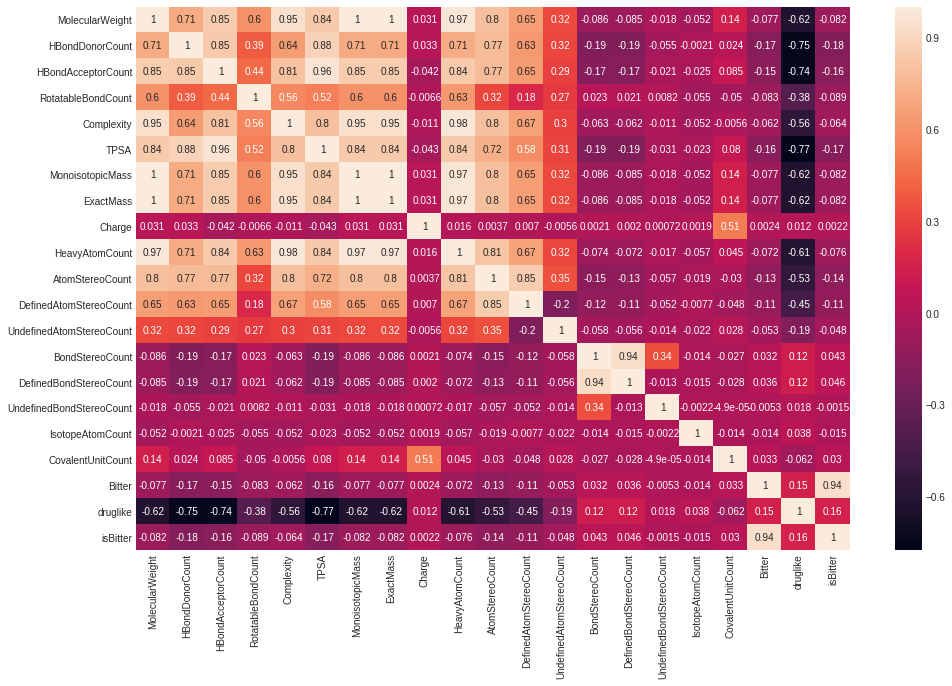

In [37]:
plt.show()

In [38]:
##number of druglike which are bitter

len(pubchem_prop[(pubchem_prop.druglike == 1) & (pubchem_prop.isBitter)])

650

In [39]:
# analysing admet properties and sweet with druglike
pubchem_prop['isSweet']=pubchem_prop.apply(lambda row:'sweet' in row['fooddb_flavor_profile'] or not row['SuperSweet'] is '' ,axis=1)

corr = admet.join(pubchem_prop).join(twod_threed).corr()['druglike'];

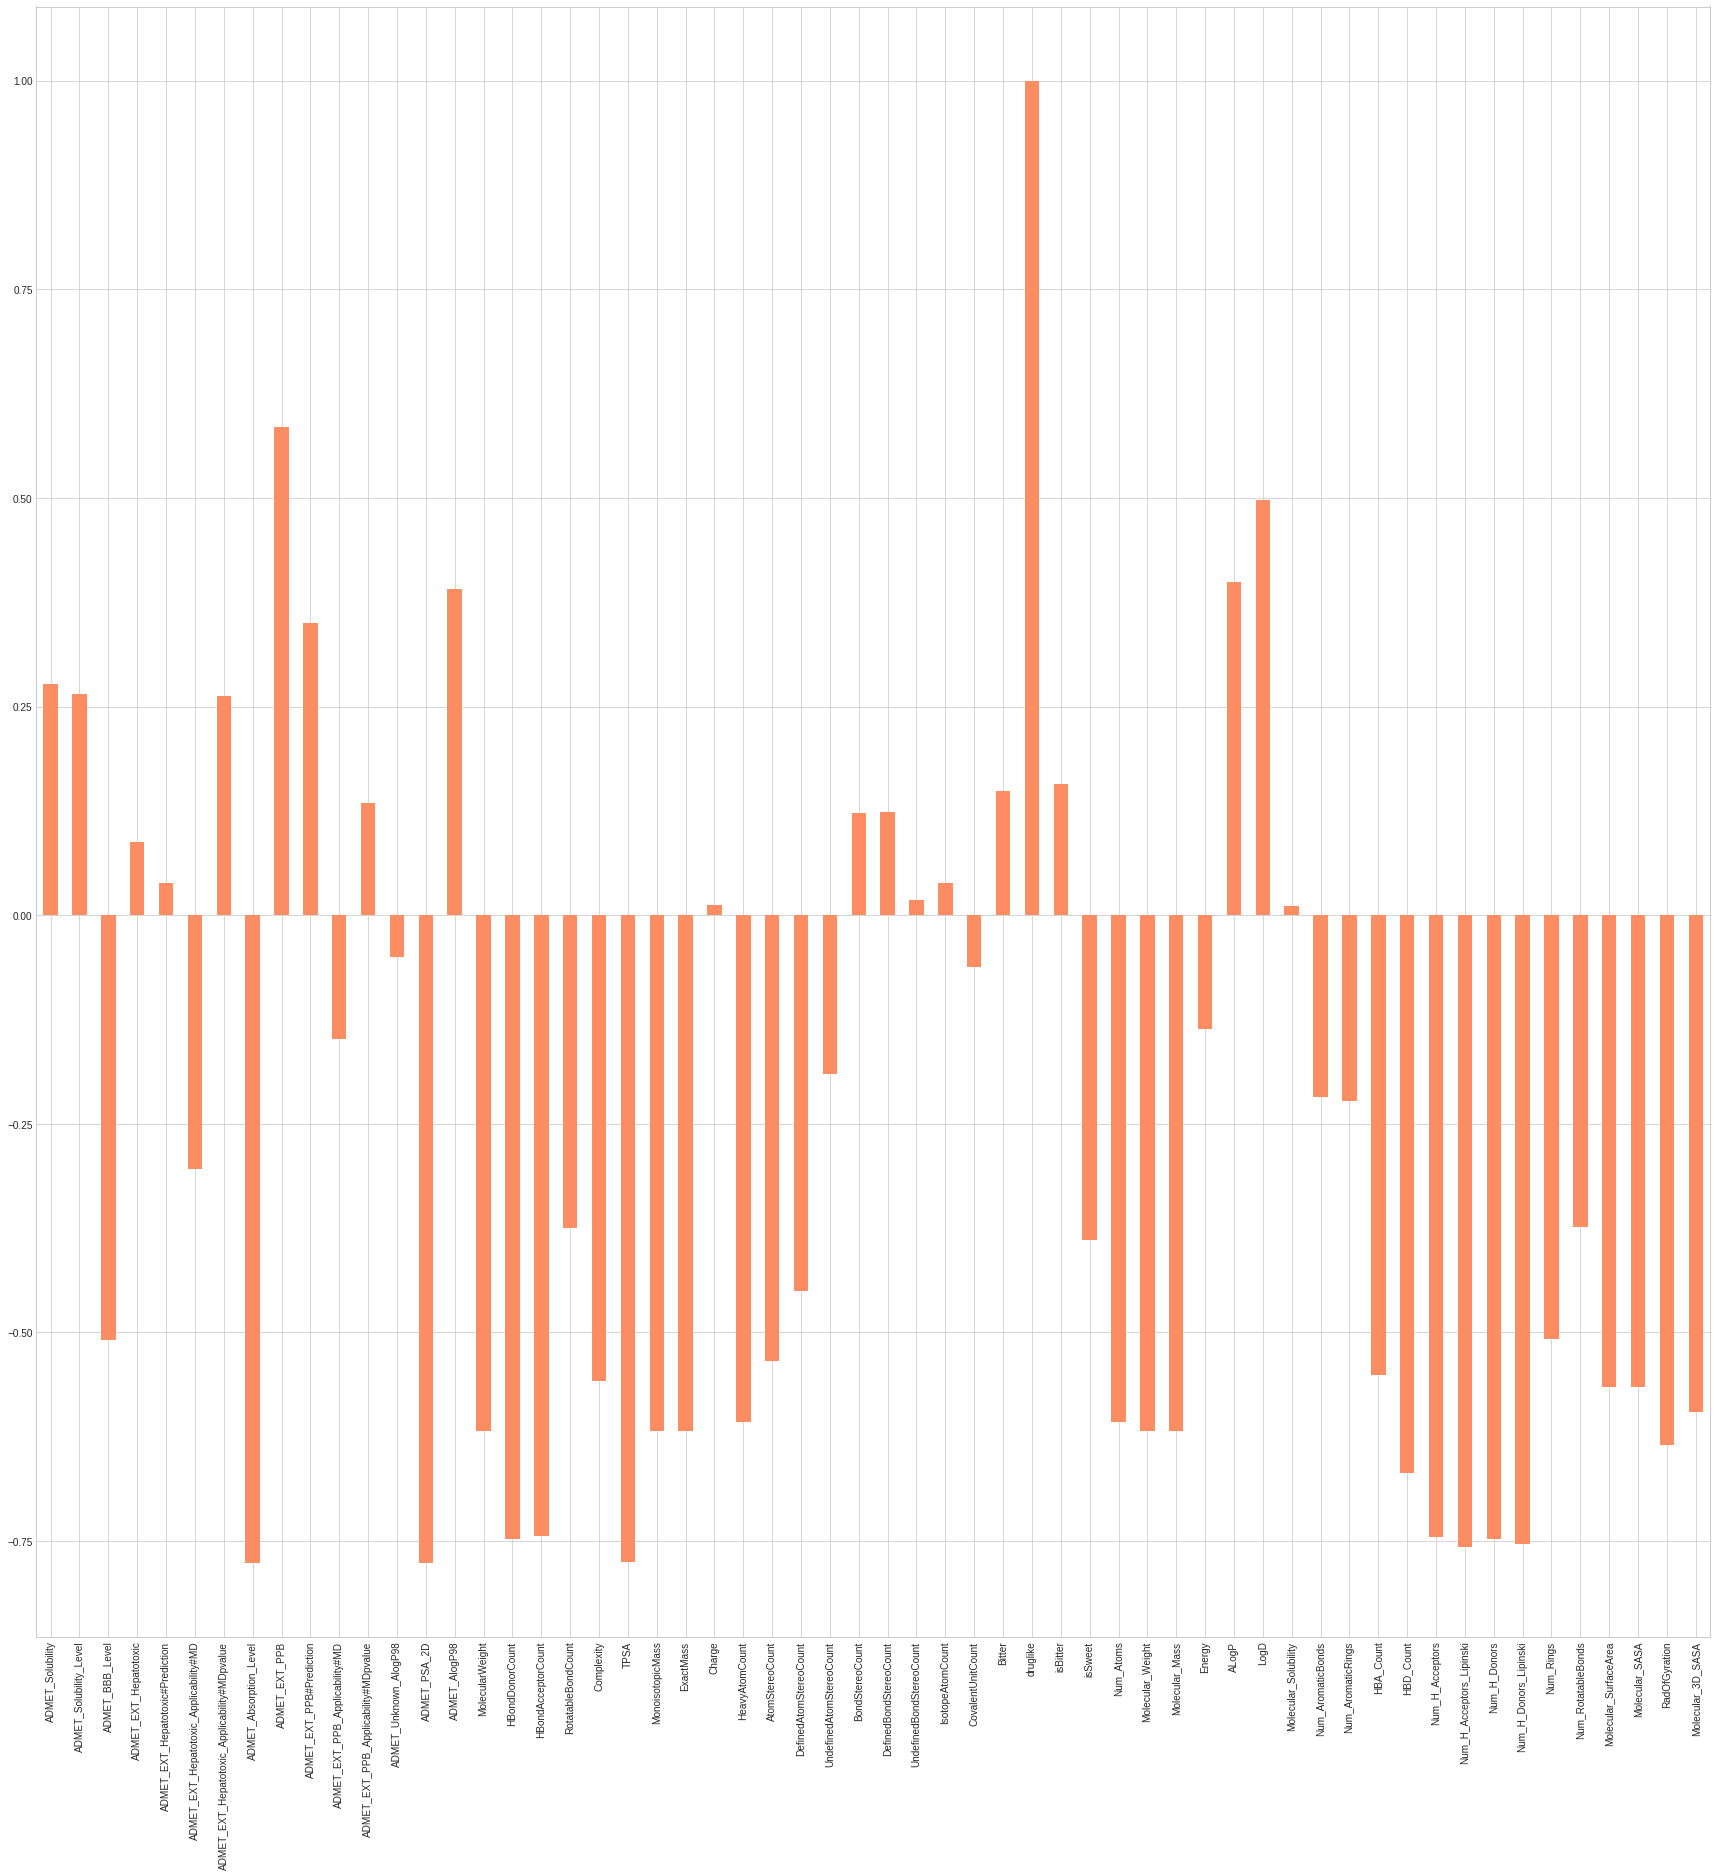

In [41]:
# plt.figure(figsize=(50,50))
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values,
#             annot=True)
# plt.show();
plt.figure(figsize=(30,30))
corr.plot.bar()
plt.show()